![lop](../../images/logo_diive1_128px.png)

<span style='font-size:32px; display:block;'>
<b>
    Format EddyPro _fluxnet_ output files for upload to FLUXNET database
</b>
</span>

---
**Notebook version**: `4` (27 Feb 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Eddypro outputs `_fluxnet_` files
- The files cannot be directly uploaded to the FLUXNET database
- The class `FormatEddyProFluxnetFileForUpload` helps in formatting the files to comply with FLUXNET requirements for data sharing

More info:
- [FLUXNET Requirements for Data Sharing](https://www.swissfluxnet.ethz.ch/index.php/knowledge-base/fluxnet-requirements/)
- [Data submission - General Information](http://www.europe-fluxdata.eu/home/guidelines/how-to-submit-data/general-information)
- [FLUXNET Variables codes](http://www.europe-fluxdata.eu/home/guidelines/how-to-submit-data/variables-codes)

</br>

# **Imports**

In [28]:
import importlib.metadata
import warnings
from datetime import datetime

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from diive.core.plotting.heatmap_datetime import HeatmapDateTime  # For plotting heatmaps
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.formats.fluxnet import FormatEddyProFluxnetFileForUpload  # Class to format output files for upload

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.79.0


</br>

# **Docstring**

In [29]:
help(FormatEddyProFluxnetFileForUpload)

Help on class FormatEddyProFluxnetFileForUpload in module diive.pkgs.formats.fluxnet:

class FormatEddyProFluxnetFileForUpload(builtins.object)
 |  FormatEddyProFluxnetFileForUpload(site: str, sourcedir: str, outdir: str, add_runid: bool = True)
 |  
 |  Helper class to convert EddyPro _fluxnet_ output files to the file
 |  format required for data upload (data sharing) to FLUXNET
 |  
 |  The class does the following:
 |  - Search source folder for _fluxnet_ files
 |  - Load data from all found files and store in dataframe
 |  - Make subset that contains required variables
 |  - Set missing values to FLUXNET format (-9999)
 |  - Rename variables by adding the FLUXNET suffix (_1_1_1)
 |  - Insert two timestamp columns denoting START and END of averaging interval
 |  - Format the two timestamp columns to FLUXNET format YYYYMMDDhhmm
 |  - Save data from dataframe to yearly files
 |  
 |  - Example notebook available in:
 |      notebooks/Formats/ConvertEddyProFluxnetFileForUpload.ipynb
 

</br>

# **Input and output folders**

In [30]:
SOURCE = r"F:\TMP\example"  # This is the folder where datafiles are searched
OUTDIR = r"F:\TMP\example"  # Output yearly CSV to this folder

</br>

# **Format data**

## Initialize

In [31]:
fxn = FormatEddyProFluxnetFileForUpload(
    site='CH-FRU',
    sourcedir=SOURCE,
    outdir=OUTDIR,
    add_runid=True)


Initiated formatting for datafiles with the following settings:
    site: CH-FRU
    source folder: F:\TMP\example
    output folder: F:\TMP\example
    add run ID: True


## Search and merge `_fluxnet_` datafiles

In [32]:
fxn.mergefiles(limit_n_files=None)


Searching for EDDYPRO-FLUXNET-CSV-30MIN files with extension .csv andID _fluxnet_ in folder F:\TMP\example ...
    Found 4 files:
   --> F:\TMP\example\eddypro_CH-CHA_FR-20240817-081003_fluxnet_2024-08-17T081023_adv.csv
   --> F:\TMP\example\eddypro_CH-CHA_FR-20240818-081003_fluxnet_2024-08-18T081023_adv.csv
   --> F:\TMP\example\eddypro_CH-CHA_FR-20240819-081003_fluxnet_2024-08-19T081023_adv.csv
   --> F:\TMP\example\eddypro_CH-CHA_FR-20240820-081003_fluxnet_2024-08-20T081024_adv.csv
Reading file eddypro_CH-CHA_FR-20240817-081003_fluxnet_2024-08-17T081023_adv.csv ...
Reading file eddypro_CH-CHA_FR-20240818-081003_fluxnet_2024-08-18T081023_adv.csv ...
Reading file eddypro_CH-CHA_FR-20240819-081003_fluxnet_2024-08-19T081023_adv.csv ...
Reading file eddypro_CH-CHA_FR-20240820-081003_fluxnet_2024-08-20T081024_adv.csv ...


## Merged dataset

In [33]:
fxn.merged_df

,AIR_MV,AIR_DENSITY,AIR_RHO_CP,AIR_CP,AOA_METHOD,AXES_ROTATION_METHOD,BOWEN,BURBA_METHOD,BADM_LOCATION_LAT,BADM_LOCATION_LONG,BADM_LOCATION_ELEV,BADM_HEIGHTC,BADM_INST_SAMPLING_INT,BADM_INST_AVERAGING_INT,BADM_INST_MODEL_SA,BADM_INST_HEIGHT_SA,BADM_INST_SA_WIND_FORMAT,BADM_INST_SA_GILL_ALIGN,BADM_SA_OFFSET_NORTH,BADM_INST_MODEL_GA_CO2,BADM_INSTPAIR_NORTHWARD_SEP_GA_CO2,BADM_INSTPAIR_EASTWARD_SEP_GA_CO2,BADM_INSTPAIR_HEIGHT_SEP_GA_CO2,BADM_INST_GA_CP_TUBE_LENGTH_GA_CO2,BADM_INST_GA_CP_TUBE_IN_DIAM_GA_CO2,...,W_NONE_MEAS_COV,W_T_SONIC_COV_IBROM,W_T_SONIC_COV_IBROM_N1626,W_T_SONIC_COV_IBROM_N0614,W_T_SONIC_COV_IBROM_N0277,W_T_SONIC_COV_IBROM_N0133,W_T_SONIC_COV_IBROM_N0065,W_T_SONIC_COV_IBROM_N0032,W_T_SONIC_COV_IBROM_N0016,W_T_SONIC_COV_IBROM_N0008,W_T_SONIC_COV_IBROM_N0004,W_NUM_SPIKES,WD_FILTER_NREX,W_SPIKE_NREX,W_ABSLIM_NREX,W_VM97_TEST,W_LGD,W_KID,W_ZCD,W_ITC,W_ITC_TEST,WBOOST_APPLIED,WPL_APPLIED,ZL,ZL_UNCORR
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-08-14 01:15:00,0.025725,1.12438,1145.35,1018.65,0.0,1.0,-0.566725,0.0,47.2102,8.41044,393.0,0.5,20.0,30.0,NaN,2.41,NaN,NaN,7.0,NaN,4.0,35.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,0.0,12.0,0.0,800000111.0,0.0,7.41221,2337.0,11.0,1.0,0.0,1.0,2.778220,2.555080
2024-08-14 01:45:00,0.025746,1.12351,1144.10,1018.33,0.0,1.0,-0.455805,0.0,47.2102,8.41044,393.0,0.5,20.0,30.0,NaN,2.41,NaN,NaN,7.0,NaN,4.0,35.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,5.0,0.0,800001111.0,0.0,34.75460,6067.0,25.0,2.0,0.0,1.0,0.156336,0.137933
2024-08-14 02:15:00,0.025897,1.11716,1135.70,1016.59,0.0,1.0,-1.147940,0.0,47.2102,8.41044,393.0,0.5,20.0,30.0,NaN,2.41,NaN,NaN,7.0,NaN,4.0,35.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,10.0,0.0,800000100.0,0.0,12.51060,42.0,13.0,1.0,0.0,1.0,0.067350,0.063555
2024-08-14 02:45:00,0.025853,1.11899,1138.12,1017.10,0.0,1.0,0.002987,0.0,47.2102,8.41044,393.0,0.5,20.0,30.0,NaN,2.41,NaN,NaN,7.0,NaN,4.0,35.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,0.0,24.0,0.0,800001111.0,0.0,11.25100,171.0,14.0,1.0,0.0,1.0,0.000854,0.015773
2024-08-14 03:15:00,0.025724,1.12456,1144.14,1017.41,0.0,1.0,-0.861950,0.0,47.2102,8.41044,393.0,0.5,20.0,30.0,NaN,2.41,NaN,NaN,7.0,NaN,4.0,35.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,6.0,0.0,800001111.0,0.0,15.30220,668.0,9.0,1.0,0.0,1.0,0.583178,0.545104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-19 16:45:00,0.025883,1.11797,1134.50,1014.79,0.0,1.0,0.118795,0.0,47.2102,8.41044,393.0,0.5,20.0,30.0,NaN,2.41,NaN,NaN,7.0,NaN,4.0,35.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,14.0,0.0,800000100.0,0.0,8.44927,15.0,5.0,1.0,0.0,1.0,-0.019597,-0.028336
2024-08-19 17:15:00,0.025854,1.11921,1136.02,1015.02,0.0,1.0,0.137909,0.0,47.2102,8.41044,393.0,0.5,20.0,30.0,NaN,2.41,NaN,NaN,7.0,NaN,4.0,35.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,11.0,0.0,800000000.0,0.0,12.74380,76.0,10.0,1.0,0.0,1.0,-0.018976,-0.026224
2024-08-19 17:45:00,0.025855,1.11914,1136.06,1015.12,0.0,1.0,-0.096932,0.0,47.2102,8.41044,393.0,0.5,20.0,30.0,NaN,2.41,NaN,NaN,7.0,NaN,4.0,35.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,15.0,0.0,800000000.0,0.0,15.34640,19.0,0.0,1.0,0.0,1.0,0.019120,0.008627


## Test for signal strength / AGC

<div class="alert alert-block alert-danger">
    <b>Do not use for H (sensible heat flux).</b> This test is only relevant for fluxes where the concentration was measured by a gas analyzer, e.g. FC, FH2O, LE, ET, N2O, CH4, etc ... 
</div>

In [34]:
FLUXCOLS = ['FC', 'LE']  # Give flux columns as list
SIGNAL_STRENGTH_COL = 'CUSTOM_AGC_MEAN'  # Name of the column storing the signal strength, typically 'CUSTOM_AGC_MEAN' for LI-7500, 'CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN' for LI-7200, or something similar
SIGNAL_STRENGTH_THRESHOLD = 90  # Signal strength threshold, flux values where threshold is exceeded are flagged as rejected
SIGNAL_STRENGTH_METHOD = 'discard above'  # 'discard above' flags fluxes where signal strength > threshold, 'discard below' where signal strength < threshold

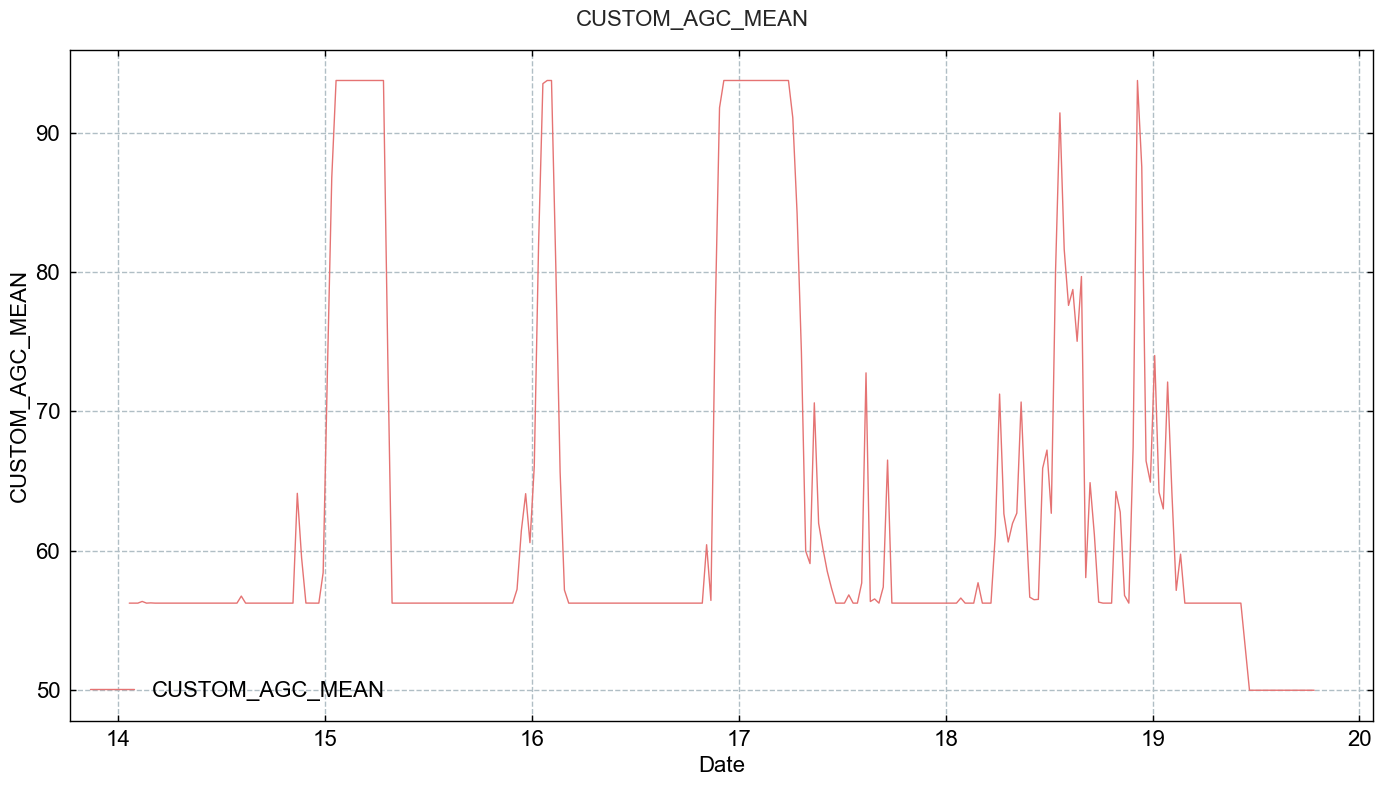

In [35]:
# TimeSeries(series=fxn.merged_df[SIGNAL_STRENGTH_COL]).plot_interactive()
TimeSeries(series=fxn.merged_df[SIGNAL_STRENGTH_COL]).plot()

In [36]:
for f in FLUXCOLS:
    fxn.remove_low_signal_data(fluxcol=f,
                               signal_strength_col=SIGNAL_STRENGTH_COL,
                               method=SIGNAL_STRENGTH_METHOD,
                               threshold=SIGNAL_STRENGTH_THRESHOLD)



Removing FC flux values where signal strength / AGC is not sufficient:

Performing signal strength / AGC quality check ...

SIGNAL STRENGTH TEST: Generating new flag variable FLAG_L2_FC_SIGNAL_STRENGTH_TEST, newly calculated from output variable CUSTOM_AGC_MEAN, with flag 0 (good values) where CUSTOM_AGC_MEAN <= 90, flag 2 (bad values) where CUSTOM_AGC_MEAN > 90 ...
CUSTOM_AGC_MEAN rejected 35 values of FC, all rejected value were removed from the dataset.

Available values of FC before removing low signal fluxes: 239
Available values of FC after removing low signal fluxes: 211

Removing all newly generated columns relating to quality check (not needed for FLUXNET), restoring original set of variables ...


Removing LE flux values where signal strength / AGC is not sufficient:

Performing signal strength / AGC quality check ...

SIGNAL STRENGTH TEST: Generating new flag variable FLAG_L2_LE_SIGNAL_STRENGTH_TEST, newly calculated from output variable CUSTOM_AGC_MEAN, with flag 0 (good 

## Remove problematic time periods
               
Use `REMOVE_DATES` to specify the time period(s) for `VAR` that are removed from the dataset.

For example:

```python
REMOVE_DATES = ['2022-06-30 23:58:30',
                ['2022-06-05 00:00:30', '2022-06-07 14:30:00']]
```
will remove the record for `2022-06-30 23:58:30` and all records between
`2022-06-05 00:00:30` (inclusive) and `2022-06-07 14:30:00` (inclusive).

This also works when providing only the date, e.g.
```python
REMOVE_DATES = [['2006-05-01', '2006-07-18']] 
```
will remove all data points between `2006-05-01` (inclusive) and `2006-07-18` (inclusive).

### Plot affected variables

In [37]:
# VAR = ['FC', 'LE', 'H', 'USTAR', 'FETCH_70', 'FETCH_90', 'FETCH_MAX']
# for v in VAR:
#     # TimeSeries(series=fxn.merged_df[v]).plot_interactive()
#     TimeSeries(series=fxn.merged_df[v]).plot()

In [38]:
# # These variables are erroneous during the defined time period
# VAR = ['FC', 'LE', 'H', 'USTAR', 'FETCH_70', 'FETCH_90', 'FETCH_MAX']  
# REMOVE_DATES = [
#     ['2023-03-20', '2023-07-09']
# ]

In [39]:
# for v in VAR:
#     fxn.remove_erroneous_data(var=v,
#                               remove_dates=REMOVE_DATES,
#                               showplot=True)

In [40]:
# # These variables are erroneous during the defined time period
# VAR = ['FC', 'LE']  
# REMOVE_DATES = [    
#     ['2017-06-09 00:30', '2017-06-12 11:00'],
#     ['2017-06-12 18:00', '2017-06-16 11:00']
# ]

In [41]:
# for v in VAR:
#     fxn.remove_erroneous_data(var=v,
#                               remove_dates=REMOVE_DATES,
#                               showplot=True)

## Format data for FLUXNET

In [42]:
fxn.apply_fluxnet_format()


Assembling subset of variables ...
    Found: ['FC', 'FC_SSITC_TEST', 'SC_SINGLE', 'CO2', 'LE', 'LE_SSITC_TEST', 'SLE_SINGLE', 'H2O', 'H', 'H_SSITC_TEST', 'SH_SINGLE', 'USTAR', 'WD', 'WS', 'FETCH_70', 'FETCH_90', 'FETCH_MAX']
    Not found: ['SW_IN_1_1_1', 'TA_1_1_1', 'RH_1_1_1', 'PA_1_1_1', 'LW_IN_1_1_1', 'PPFD_IN_1_1_1', 'G_1_1_1', 'NETRAD_1_1_1', 'TS_1_1_1', 'P_1_1_1', 'SWC_1_1_1']

Setting all missing values to -9999 ...

The following variables are renamed to comply with FLUXNET variable codes:
    RENAMED --> SC_SINGLE was renamed to SC
    RENAMED --> SLE_SINGLE was renamed to SLE
    RENAMED --> SH_SINGLE was renamed to SH

The following variables have been renamed:
    RENAMED --> FC was renamed to FC_1_1_1
    RENAMED --> FC_SSITC_TEST was renamed to FC_SSITC_TEST_1_1_1
    RENAMED --> SC was renamed to SC_1_1_1
    RENAMED --> CO2 was renamed to CO2_1_1_1
    RENAMED --> LE was renamed to LE_1_1_1
    RENAMED --> LE_SSITC_TEST was renamed to LE_SSITC_TEST_1_1_1
    RENAMED 

## Save yearly `CSV` files

In [43]:
fxn.export_yearly_files()


Saving yearly CSV files ...
    --> Saved file F:\TMP\example\CH-FRU_2024_fluxes_meteo_20240822.csv.


</br>

# **Check FLUXNET data**

- The merged file data from all files can be directly returned with `.get_data()`
- Note that the dataframe below does not show exactly how the data look like in the formatted data files, but how data were stored in `diive`, hence the timestamp index `TIMESTAMP_MIDDLE`
- The yearly files do not contain the timestamp index `TIMESTAMP_MIDDLE`

## Dataframe that was used to generate yearly files

In [44]:
data_fluxnet = fxn.get_data()
data_fluxnet

,TIMESTAMP_START,TIMESTAMP_END,FC_1_1_1,FC_SSITC_TEST_1_1_1,SC_1_1_1,CO2_1_1_1,LE_1_1_1,LE_SSITC_TEST_1_1_1,SLE_1_1_1,H2O_1_1_1,H_1_1_1,H_SSITC_TEST_1_1_1,SH_1_1_1,USTAR_1_1_1,WD_1_1_1,WS_1_1_1,FETCH_70_1_1_1,FETCH_90_1_1_1,FETCH_MAX_1_1_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,
2024-08-14 01:15:00,202408140100,202408140130,33.10840,1.0,-9999.000000,495.095,12.0917,1.0,-9999.000000,23.6909,-6.852700,0.0,-9999.000000,0.038737,132.9270,0.375759,-9999.0000,-9999.0000,-9999.0000
2024-08-14 01:45:00,202408140130,202408140200,110.22800,1.0,0.390611,502.575,161.5850,1.0,-1.328490,23.1133,-73.651200,1.0,0.451412,0.223090,311.1140,0.563905,51.7536,77.5363,28.3067
2024-08-14 02:15:00,202408140200,202408140230,13.52350,0.0,-4.559510,414.750,49.2341,0.0,-7.257440,19.9328,-56.517900,0.0,3.101560,0.270479,245.7800,1.728790,47.1261,70.6034,25.7756
2024-08-14 02:45:00,202408140230,202408140300,-13.47620,1.0,0.809568,430.317,-23.3607,2.0,2.123100,20.8611,-0.069768,2.0,-0.901699,0.124400,144.7180,1.162360,-9999.0000,-9999.0000,-9999.0000
2024-08-14 03:15:00,202408140300,202408140330,16.45230,1.0,0.917290,447.869,18.4352,0.0,1.432160,21.4833,-15.890200,0.0,-2.367320,0.086283,117.6440,0.853670,-9999.0000,-9999.0000,-9999.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-19 16:45:00,202408191630,202408191700,-10.57130,0.0,0.044676,418.415,187.7560,0.0,0.616174,16.6754,22.304400,0.0,-0.524619,0.299453,31.7682,1.793950,44.5186,66.6970,24.3495
2024-08-19 17:15:00,202408191700,202408191730,-8.27013,0.0,-0.005200,418.315,146.2560,0.0,1.019160,17.1211,20.170100,0.0,-0.579390,0.292699,22.0988,1.821400,46.3287,69.4088,25.3395
2024-08-19 17:45:00,202408191730,202408191800,-4.43956,0.0,0.109860,420.428,100.4200,0.0,0.411758,17.3013,-9.733890,0.0,-0.002523,0.229010,354.6490,2.068030,40.8577,61.2123,22.3472


In [45]:
data_fluxnet.columns.to_list()

['TIMESTAMP_START',
 'TIMESTAMP_END',
 'FC_1_1_1',
 'FC_SSITC_TEST_1_1_1',
 'SC_1_1_1',
 'CO2_1_1_1',
 'LE_1_1_1',
 'LE_SSITC_TEST_1_1_1',
 'SLE_1_1_1',
 'H2O_1_1_1',
 'H_1_1_1',
 'H_SSITC_TEST_1_1_1',
 'SH_1_1_1',
 'USTAR_1_1_1',
 'WD_1_1_1',
 'WS_1_1_1',
 'FETCH_70_1_1_1',
 'FETCH_90_1_1_1',
 'FETCH_MAX_1_1_1']

## Overview of variables and some stats

In [46]:
# print(*data_fluxnet.columns, sep = "\n")
data_fluxnet.describe().T

,count,mean,std,min,25%,50%,75%,max
FC_1_1_1,276.0,-2355.031396,4250.369939,-9999.0,-27.013650,-12.516850,6.853575,110.228000
FC_SSITC_TEST_1_1_1,276.0,-1339.880435,3413.216601,-9999.0,0.000000,0.000000,1.000000,2.000000
SC_1_1_1,276.0,-1920.089013,3945.722990,-9999.0,-2.704025,-0.090863,0.521721,11.047800
CO2_1_1_1,276.0,-932.263022,3574.725026,-9999.0,396.766000,424.329500,507.754000,847.494000
LE_1_1_1,276.0,-1512.360172,3704.452541,-9999.0,-15.668425,27.789100,147.086250,403.386000
LE_SSITC_TEST_1_1_1,276.0,-905.159420,2875.204145,-9999.0,0.000000,0.000000,1.000000,2.000000
SLE_1_1_1,276.0,-1340.989221,3412.786989,-9999.0,-5.390033,-0.392506,1.144108,25.112500
H2O_1_1_1,276.0,-886.368288,2881.149917,-9999.0,16.656750,21.851400,23.862275,38.480800
H_1_1_1,276.0,-23.589553,603.280492,-9999.0,-1.722545,1.191035,22.327050,99.632600
H_SSITC_TEST_1_1_1,276.0,-35.550725,601.910456,-9999.0,0.000000,1.000000,1.000000,2.000000


## Plot some key variables
- Keep in mind that FLUXNET requires missing values as `-9999` when looking at the plots

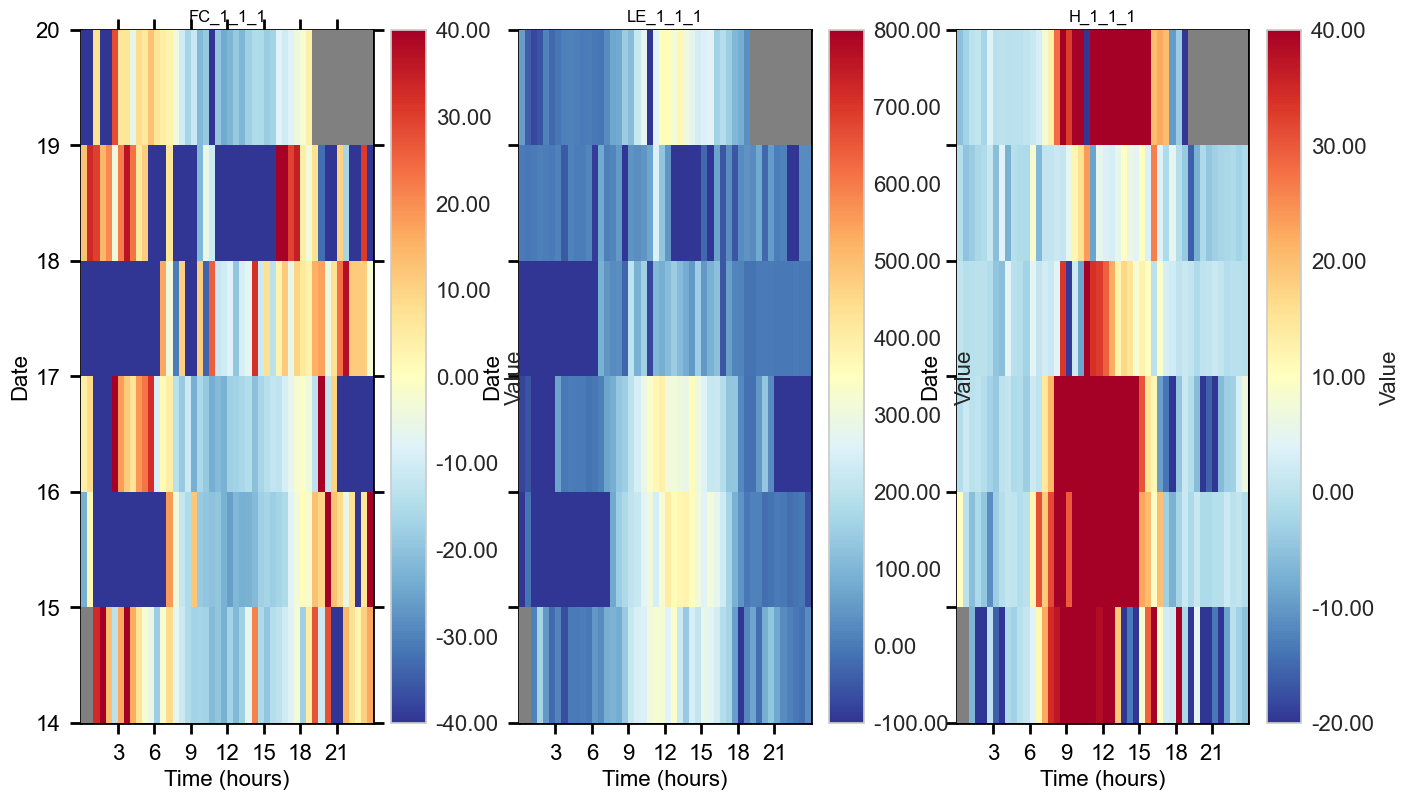

In [47]:
fig = plt.figure(facecolor='white', figsize=(16, 9))
gs = gridspec.GridSpec(1, 3)  # rows, cols
ax_fc = fig.add_subplot(gs[0, 0])
ax_le = fig.add_subplot(gs[0, 1])
ax_ta = fig.add_subplot(gs[0, 2])
HeatmapDateTime(ax=ax_fc, series=data_fluxnet['FC_1_1_1'], vmin=-40, vmax=40).plot()
HeatmapDateTime(ax=ax_le, series=data_fluxnet['LE_1_1_1'], vmin=-100, vmax=800).plot()
HeatmapDateTime(ax=ax_ta, series=data_fluxnet['H_1_1_1'], vmin=-20, vmax=40).plot()
ax_fc.set_title("FC_1_1_1", color='black')
ax_le.set_title("LE_1_1_1", color='black')
ax_ta.set_title("H_1_1_1", color='black')
ax_le.tick_params(left=True, right=False, top=False, bottom=True,
                  labelleft=False, labelright=False, labeltop=False, labelbottom=True)
ax_ta.tick_params(left=True, right=False, top=False, bottom=True,
                  labelleft=False, labelright=False, labeltop=False, labelbottom=True)

## Plot all variables

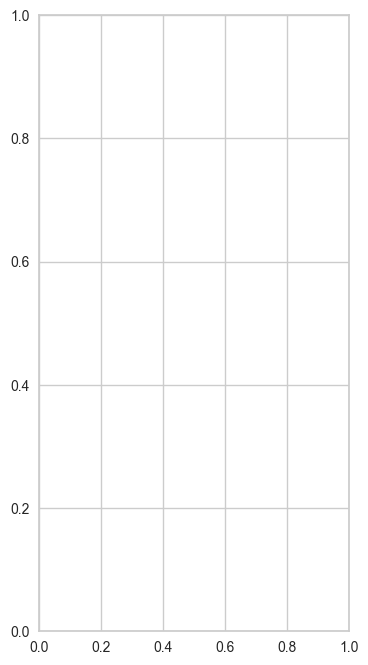

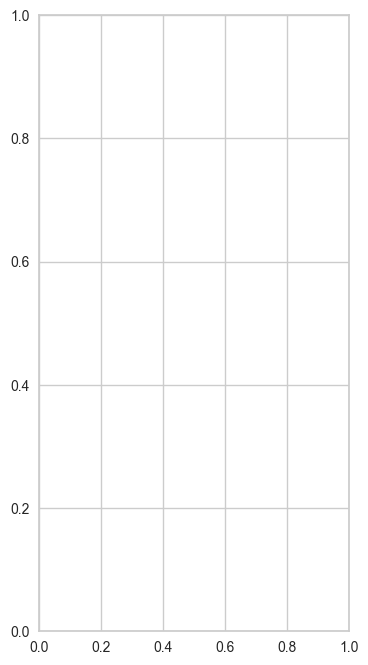

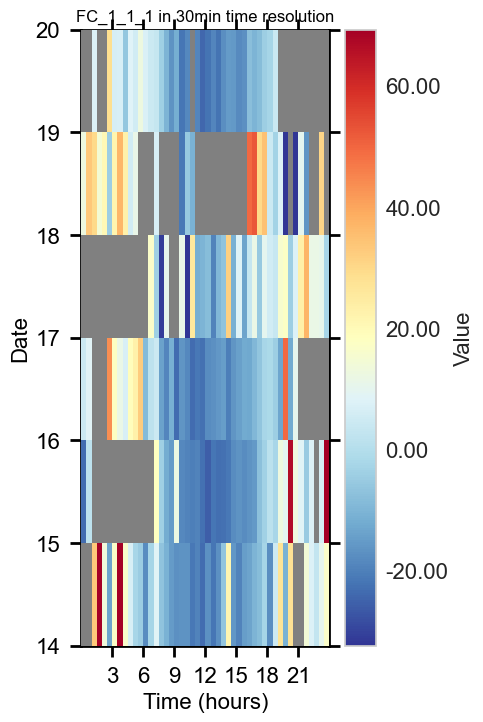

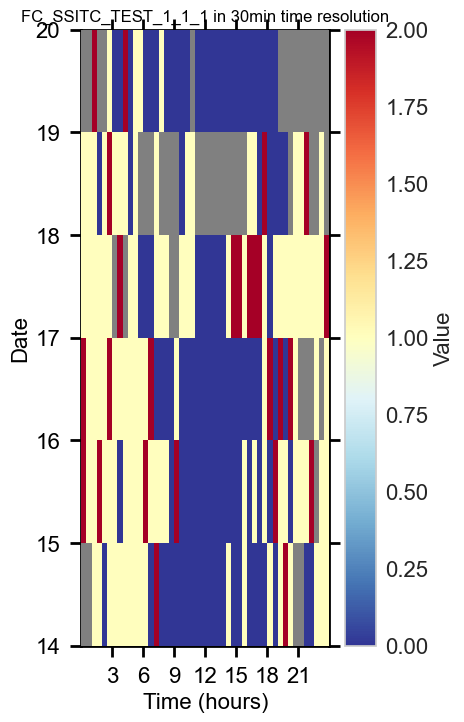

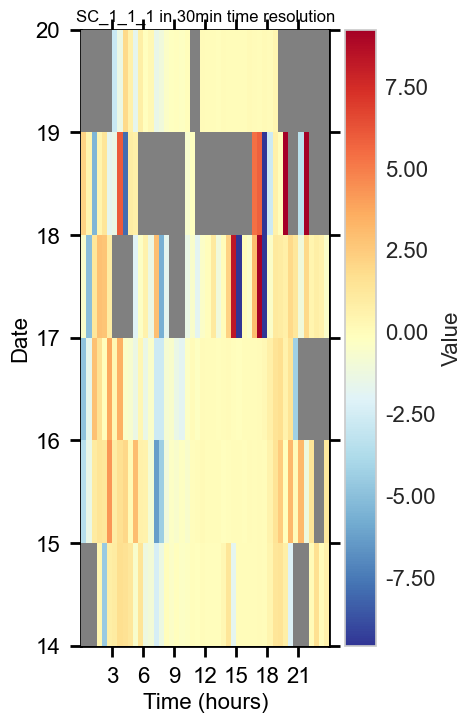

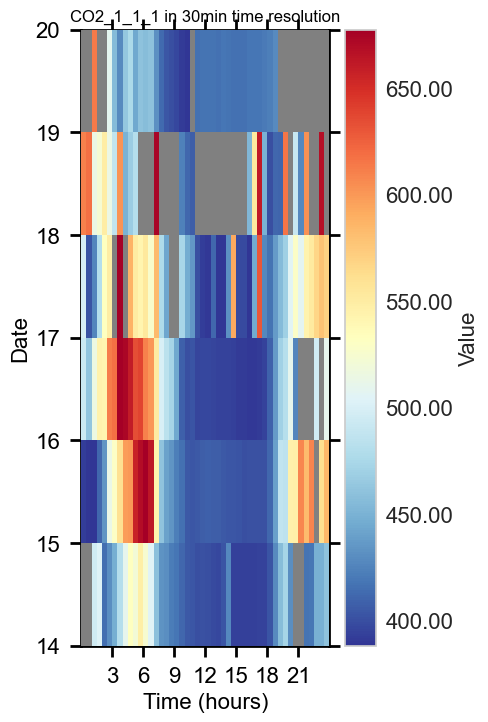

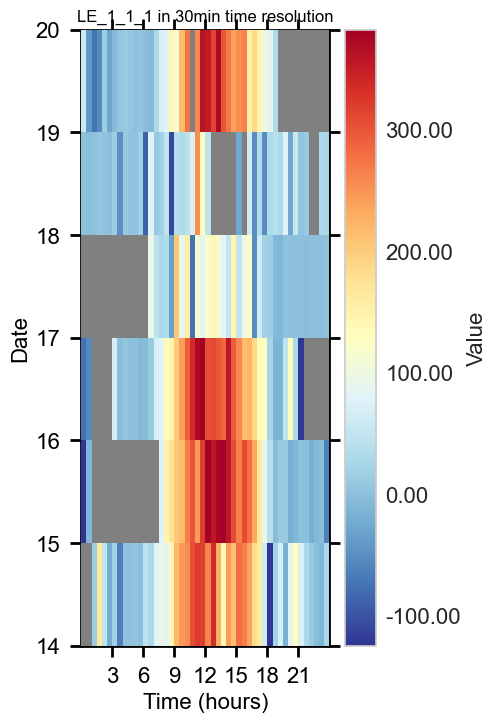

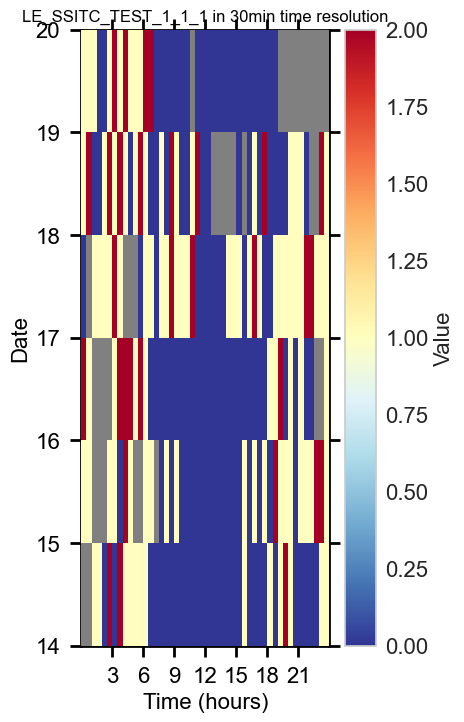

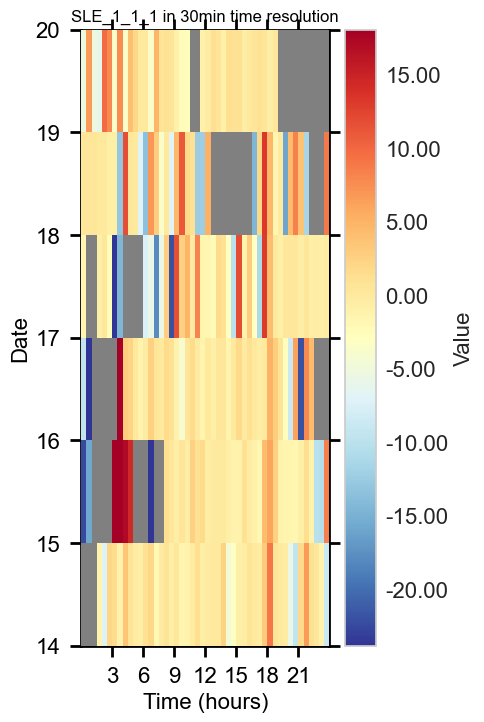

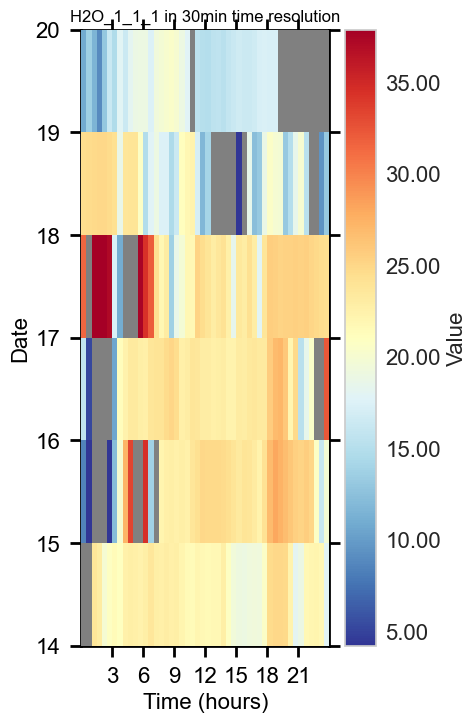

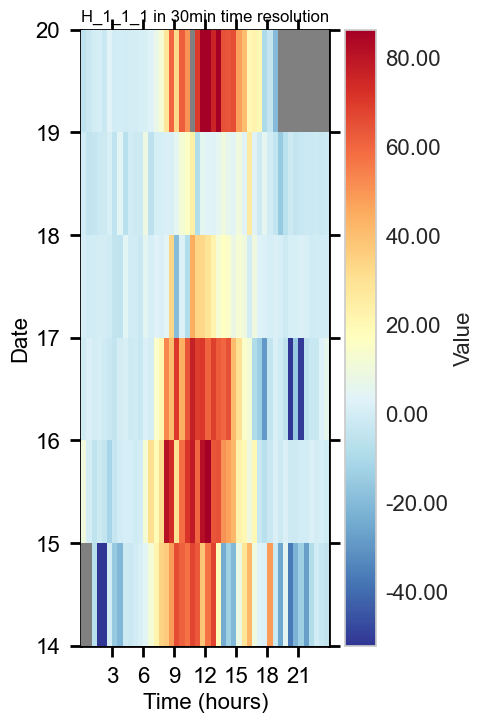

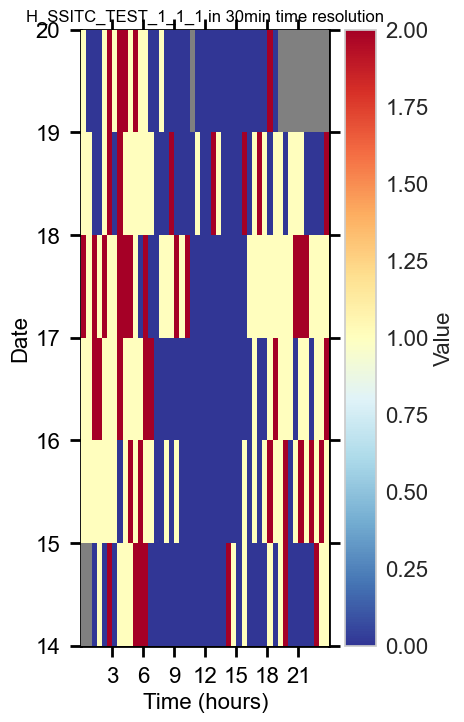

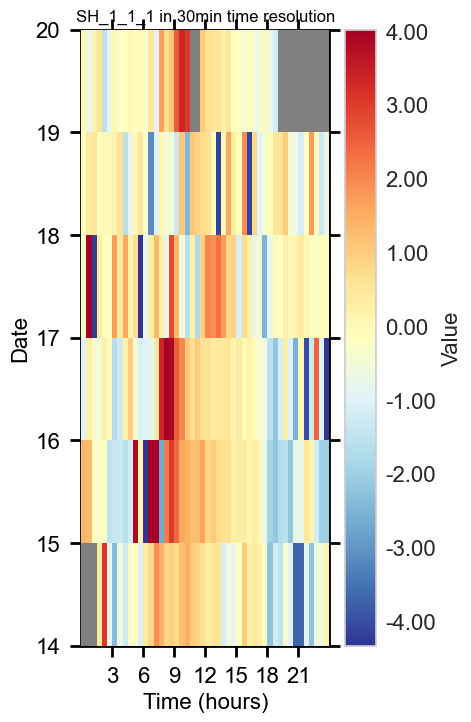

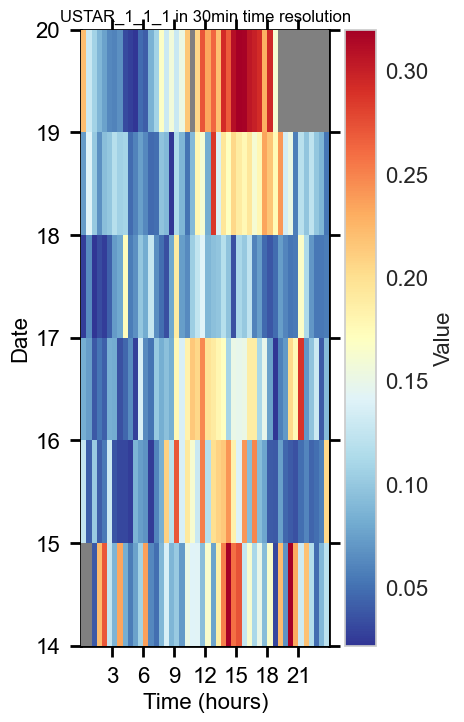

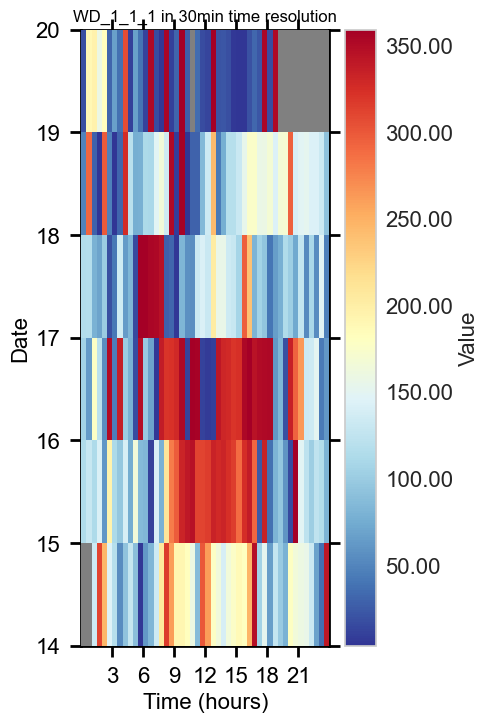

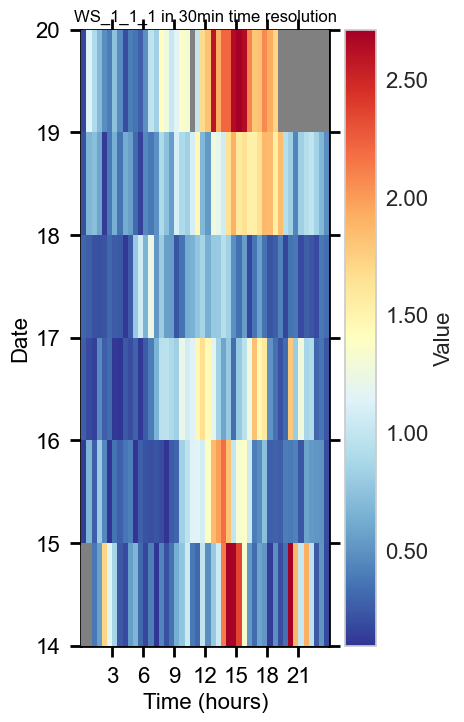

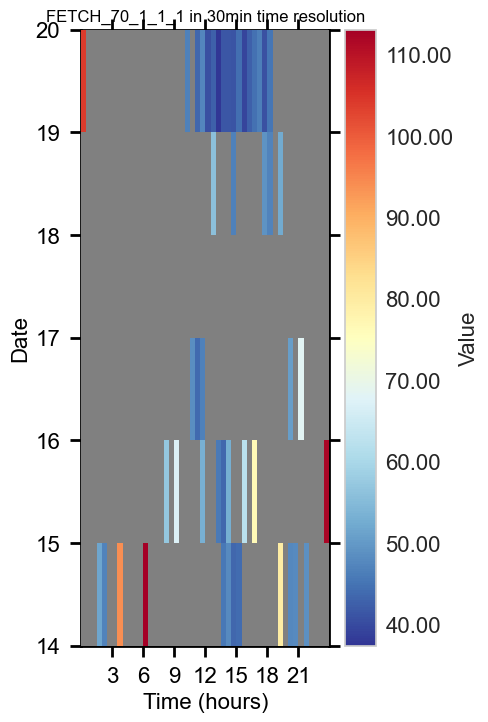

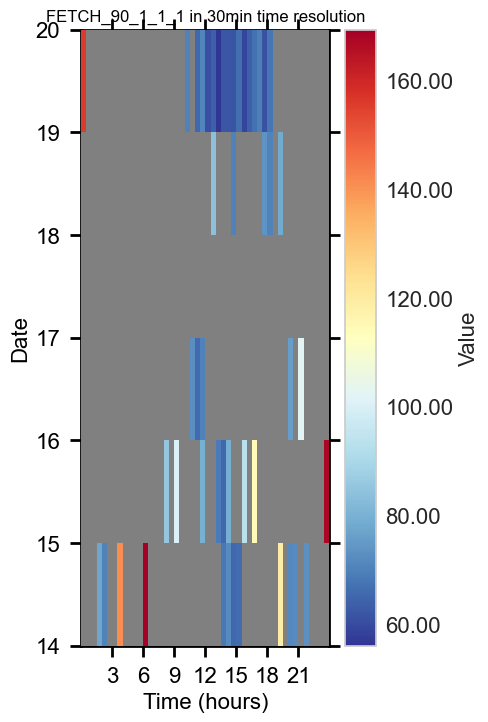

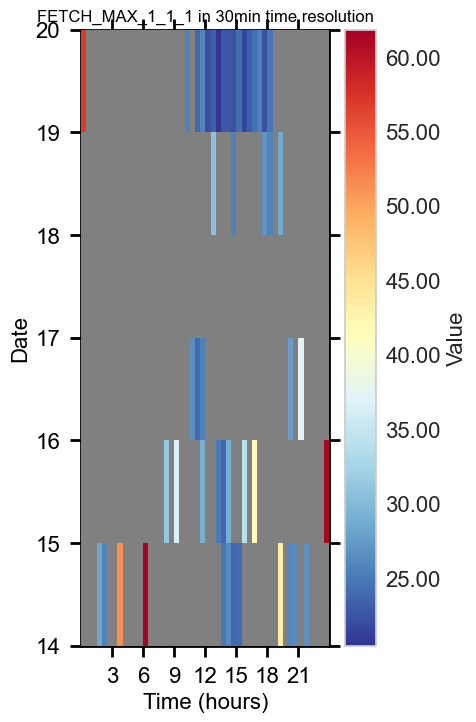

In [48]:
for col in data_fluxnet.columns:
    series = data_fluxnet[col].copy()
    series.replace(to_replace=-9999, value=np.nan, inplace=True)
    try:
        fig = plt.figure(facecolor='white', figsize=(4, 8))
        gs = gridspec.GridSpec(1, 1)  # rows, cols
        ax = fig.add_subplot(gs[0, 0])
        vmin = series.quantile(.01)
        vmax = series.quantile(.99)
        HeatmapDateTime(ax=ax, series=series, vmin=vmin, vmax=vmax).plot()
        ax_fc.set_title(col, color='black')
        fig.show()
    except TypeError:
        pass

</br>

# **End of notebook**

In [49]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-08-22 15:58:53
